# The e2e Model Lifecycle on SAS Viya Platform

In this notebook, 

1. Build and train the model.
2. Create an API of the model. (Here we have put it in a flask API).
3. Create the requirements file containing all the required libraries.
4. Create the docker file with necessary environment setup and start-up operations.
5. Build the docker image.

I train XGboost model for testing Docker Private ML environment

## Libraries

In [1]:
# Mongo Library

import pymongo

# ML libraries 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
from xgboost import XGBClassifier 

# Tool libraries

# import json
import os
import pprint
import json
# import requests as req
# import random
# import pickle
import zipfile
# import urllib
# import base64
# import time
# import sys

# import sasctl

## Data Engineering

### Load Data from Mongo

In [2]:
#Connect to mongodb container

conn = pymongo.MongoClient('mongo', 27017)

In [3]:
conn

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

In [4]:
db = conn.training
collection = db.churn_data

In [5]:
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3667,1,9,
1,1,1300,70053,68400,HomeImp,Other,7,0,2,121.833,0,14,
2,1,1500,13500,16700,HomeImp,Other,4,0,0,149.467,1,10,
3,1,1500,,,,,,,,,,,
4,0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333,0,14,


### Declare data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5960 non-null object
VALUE      5960 non-null object
REASON     5960 non-null object
JOB        5960 non-null object
YOJ        5960 non-null object
DEROG      5960 non-null object
DELINQ     5960 non-null object
CLAGE      5960 non-null object
NINQ       5960 non-null object
CLNO       5960 non-null object
DEBTINC    5960 non-null object
dtypes: int64(2), object(11)
memory usage: 651.9+ KB


In [7]:
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [8]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333336,0.0,14.0,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null category
LOAN       5960 non-null int64
MORTDUE    5442 non-null float32
VALUE      5848 non-null float32
REASON     5960 non-null object
JOB        5960 non-null object
YOJ        5445 non-null float32
DEROG      5252 non-null float32
DELINQ     5380 non-null float32
CLAGE      5652 non-null float32
NINQ       5450 non-null float32
CLNO       5738 non-null float32
DEBTINC    4693 non-null float32
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 401.7+ KB


### Declare variables 

In [10]:
#target var
target = df.select_dtypes('category').columns

#categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)

#input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

inputs= class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

Index(['BAD'], dtype='object')
['REASON', 'JOB']
['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [11]:
df[inputs]

,REASON,JOB,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,HomeImp,Other,1100,25860.0,39025.0,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
1,HomeImp,Other,1300,70053.0,68400.0,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
2,HomeImp,Other,1500,13500.0,16700.0,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
3,,,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HomeImp,Office,1700,97800.0,112000.0,3.0,0.0,0.0,93.333336,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,DebtCon,Other,89000,54576.0,92937.0,16.0,0.0,0.0,208.692062,0.0,15.0,35.859970
5956,DebtCon,Other,89200,54045.0,92924.0,15.0,0.0,0.0,212.279694,0.0,15.0,35.556591
5957,DebtCon,Other,89800,50370.0,91861.0,14.0,0.0,0.0,213.892715,0.0,16.0,34.340881
5958,DebtCon,Other,88900,48919.0,93371.0,15.0,0.0,1.0,205.650162,0.0,15.0,34.818260


### Impute missing

In [12]:
categorical_imputer = SimpleImputer(missing_values = '', strategy = 'most_frequent')
numerical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(data=categorical_imputed, columns=class_inputs)
df_categorical_imputed.info()

print('-'*50)

#Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(data=numerical_imputed, columns=numerical_inputs)
df_numerical_imputed.info()
df_numerical_imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 2 columns):
REASON    5960 non-null object
JOB       5960 non-null object
dtypes: object(2)
memory usage: 93.2+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 10 columns):
LOAN       5960 non-null float64
MORTDUE    5960 non-null float64
VALUE      5960 non-null float64
YOJ        5960 non-null float64
DEROG      5960 non-null float64
DELINQ     5960 non-null float64
CLAGE      5960 non-null float64
NINQ       5960 non-null float64
CLNO       5960 non-null float64
DEBTINC    5960 non-null float64
dtypes: float64(10)
memory usage: 465.8 KB


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915
1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915
2,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915
3,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...
5955,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970
5956,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591
5957,89800.0,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881
5958,88900.0,48919.000000,93371.000000,15.000000,0.00000,1.000000,205.650162,0.000000,15.000000,34.818260


### One-Hot encoding for categorical variables

In [13]:
encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
categories

# print(categorical_encoded.toarray())
df_categorical_encoded = pd.DataFrame(data=categorical_encoded.toarray(), columns=categories)
df_categorical_encoded.info()
df_categorical_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 8 columns):
DebtCon    5960 non-null float64
HomeImp    5960 non-null float64
Mgr        5960 non-null float64
Office     5960 non-null float64
Other      5960 non-null float64
ProfExe    5960 non-null float64
Sales      5960 non-null float64
Self       5960 non-null float64
dtypes: float64(8)
memory usage: 372.6 KB


,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5955,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### ABT

In [14]:
abt = pd.concat([df[target], df_numerical_imputed, df_categorical_encoded], axis=1)
abt


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,1,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,89000.0,54576.000000,92937.000000,16.000000,0.00000,0.000000,208.692062,0.000000,15.000000,35.859970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,0,89200.0,54045.000000,92924.000000,15.000000,0.00000,0.000000,212.279694,0.000000,15.000000,35.556591,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,0,89800.0,50370.000000,91861.000000,14.000000,0.00000,0.000000,213.892715,0.000000,16.000000,34.340881,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,0,88900.0,48919.000000,93371.000000,15.000000,0.00000,1.000000,205.650162,0.000000,15.000000,34.818260,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
abt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 19 columns):
BAD        5960 non-null category
LOAN       5960 non-null float64
MORTDUE    5960 non-null float64
VALUE      5960 non-null float64
YOJ        5960 non-null float64
DEROG      5960 non-null float64
DELINQ     5960 non-null float64
CLAGE      5960 non-null float64
NINQ       5960 non-null float64
CLNO       5960 non-null float64
DEBTINC    5960 non-null float64
DebtCon    5960 non-null float64
HomeImp    5960 non-null float64
Mgr        5960 non-null float64
Office     5960 non-null float64
Other      5960 non-null float64
ProfExe    5960 non-null float64
Sales      5960 non-null float64
Self       5960 non-null float64
dtypes: category(1), float64(18)
memory usage: 890.6 KB


## Model Development

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)], 
                                                                    abt[target], 
                                                                    test_size=0.33, random_state=27513)

## Look at traditional models...

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    ]

labels = ['Logit', 'DTree', 'RFor', 'GBoost']

In [18]:
models = []
models_dic = {}

for label, classifier in zip(labels, classifiers):
    model = classifier.fit(X_train, y_train.values.ravel())
    models_dic = {'label': label, 'model': model}
    models.append(models_dic)

pprint.pprint(models)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[{'label': 'Logit',
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)},
 {'label': 'DTree',
  'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')},
 {'label': 'RFor',
  'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                 

In [19]:
print('Misclassification Rates')
for m in models:
    dt_misclassification = 1 - metrics.accuracy_score(y_test, m['model'].predict(X_test))
    print('{} :'.format(m['label']), dt_misclassification)

Misclassification Rates
Logit : 0.17996949669547535
DTree : 0.12353838332486022
RFor : 0.09405185561769192
GBoost : 0.08947635993899339


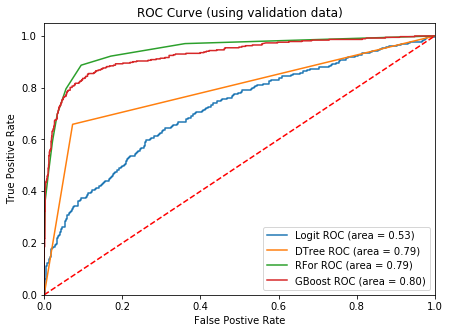

In [20]:
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

In [21]:
del_models = ['Logit', 'DTree']

for model_dict in models:
    if model_dict['label'] in del_models:
        models.remove(model_dict)

## Model Assessment

In [22]:
%%time

xgb = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=100,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.118708	validation_0-logloss:0.632926	validation_1-error:0.11032	validation_1-logloss:0.63152
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.128725	validation_0-logloss:0.589832	validation_1-error:0.127605	validation_1-logloss:0.589081
[2]	validation_0-error:0.122214	validation_0-logloss:0.54709	validation_1-error:0.114896	validation_1-logloss:0.544502
[3]	validation_0-error:0.116203	validation_0-logloss:0.51257	validation_1-error:0.113371	validation_1-logloss:0.509829
[4]	validation_0-error:0.116704	validation_0-logloss:0.482234	validation_1-error:0.105236	validation_1-logloss:0.478549
[5]	validation_0-error:0.122965	validation_0-logloss:0.459565	validation_1-error:0.120488	validation_1-logloss:0.456959
[6]	validation_0-error:0.123216	validation_0-logloss:0.437603	validation_1-error:0.120996	validation_1-logloss:0.435859

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12]	validation_0-error:0.111946	validation_0-logloss:0.35088	validation_1-error:0.10422	validation_1-logloss:0.350536
[13]	validation_0-error:0.111195	validation_0-logloss:0.341514	validation_1-error:0.101169	validation_1-logloss:0.340931
[14]	validation_0-error:0.110944	validation_0-logloss:0.332374	validation_1-error:0.100661	validation_1-logloss:0.332341
[15]	validation_0-error:0.109942	validation_0-logloss:0.325463	validation_1-error:0.100661	validation_1-logloss:0.325786
[16]	validation_0-error:0.108941	validation_0-logloss:0.317579	validation_1-error:0.098627	validation_1-logloss:0.317841
[17]	validation_0-error:0.109692	validation_0-logloss:0.311061	validation_1-error:0.099644	validation_1-logloss:0.31158
[18]	validation_0-error:0.107939	validation_0-logloss:0.305378	validation_1-error:0.100153	validation_1-logloss:0.306911
[19]	validation_0-error:0.105435	validation_0-logloss:0.300127	validation_1-error:0.097611	validation_1-logloss:0.303073
[20]	validation_0-error:0.103431	va

[80]	validation_0-error:0.073879	validation_0-logloss:0.193134	validation_1-error:0.086426	validation_1-logloss:0.227599
[81]	validation_0-error:0.073629	validation_0-logloss:0.192735	validation_1-error:0.085409	validation_1-logloss:0.227167
[82]	validation_0-error:0.072627	validation_0-logloss:0.191803	validation_1-error:0.086426	validation_1-logloss:0.226397
[83]	validation_0-error:0.072627	validation_0-logloss:0.191003	validation_1-error:0.087443	validation_1-logloss:0.225936
[84]	validation_0-error:0.072627	validation_0-logloss:0.189264	validation_1-error:0.084901	validation_1-logloss:0.224768
[85]	validation_0-error:0.071625	validation_0-logloss:0.188149	validation_1-error:0.085918	validation_1-logloss:0.223909
[86]	validation_0-error:0.071625	validation_0-logloss:0.187155	validation_1-error:0.085409	validation_1-logloss:0.223527
[87]	validation_0-error:0.070874	validation_0-logloss:0.18629	validation_1-error:0.085409	validation_1-logloss:0.222896
[88]	validation_0-error:0.070624	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [23]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, xgb.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification)

Misclassification Rates
 XGBoost : 0.08490086426029486


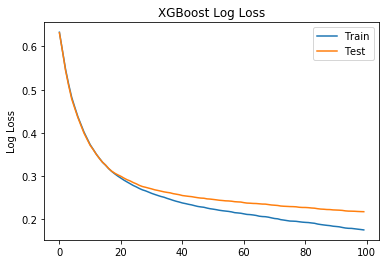

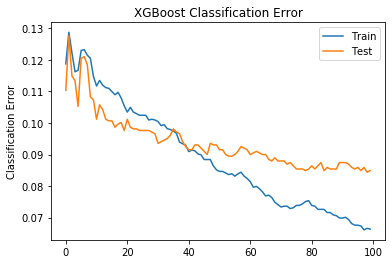

In [24]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


In [25]:
models.append({'label': 'XGBoost','model': xgb})

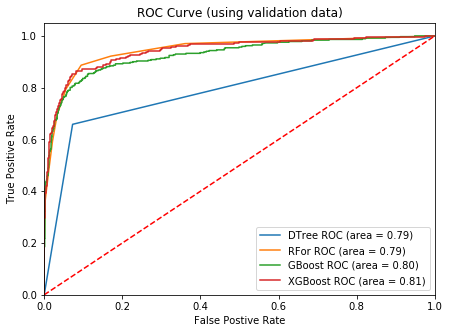

In [26]:
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

#### The champion model is Rfor. And the challenger is Gboost

## Machine Learning Engineering

### Create ML pipelines

# Rfor pipeline

In [27]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

rfor_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())

])

## Gboost pipeline

In [28]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

gboost_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())

])

## XGBoost pipeline

In [29]:
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

xgb_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())

])

## Test fit and predict

In [30]:
Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(df[df.columns.difference(target)], 
                                                                    df[target], 
                                                                    test_size=0.33, random_state=27513)

In [31]:
rfor_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=rfor_pipeline.predict_proba(Prod_X_test)
# Prod_y_predict=rfor_pipeline.predict(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


array([[0.6, 0.4],
       [0.9, 0.1],
       [0.5, 0.5],
       ...,
       [0.7, 0.3],
       [1. , 0. ],
       [0.9, 0.1]])

In [32]:
rfor_pipeline.score(Prod_X_test, Prod_y_test)

0.9201830198271479

In [33]:
gboost_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=gboost_pipeline.predict_proba(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0.53352798, 0.46647202],
       [0.94071316, 0.05928684],
       [0.54957969, 0.45042031],
       ...,
       [0.75062912, 0.24937088],
       [0.97327314, 0.02672686],
       [0.95702072, 0.04297928]])

In [34]:
gboost_pipeline.score(Prod_X_test, Prod_y_test)

0.9140823589222166

In [35]:
xgb_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=xgb_pipeline.predict_proba(Prod_X_test)
Prod_y_predict

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0.4606455 , 0.5393545 ],
       [0.9467305 , 0.05326953],
       [0.54331553, 0.45668444],
       ...,
       [0.6821841 , 0.31781593],
       [0.97048986, 0.02951015],
       [0.9581864 , 0.04181362]], dtype=float32)

In [36]:
xgb_pipeline.score(Prod_X_test, Prod_y_test)

0.9115404168784952

# Model Deployment of Sklearn Random Forest

For Model Deployment purpose, we need some files:

- Required

    0. requirement.txt
    1. score.py
    2. model.pkl
    3. inputVar.json
    4. outputVar.json
    
    
- Optional
    
    5. train.py
    6. fileMetadata.json
    7. ModelProperties.json
    8. dmcas_fitstat.json
    9. dmcas_roc
    10. dmcas_lift


In [37]:
from viyapy.services import utils

In [38]:
! mkdir -p experiment_rfor experiment_gboost experiment_xgboost

## 0. requirement.txt

In [39]:
! pip freeze > ./experiment_rfor/requirement.txt
! pip freeze > ./experiment_gboost/requirement.txt
! pip freeze > ./experiment_xgboost/requirement.txt

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


## 1. Score.py 

About the Score code, you have to put the pickle file on the Model Manager file system.
To avoid that (for now) use the "write binary" method.

In [41]:
%%writefile ./experiment_rfor/score.py

import argparse
import os
import os.path
import sys
import pandas as pd
import numpy as np
import joblib

# parse arguments
parser = argparse.ArgumentParser(description='Score')
parser.add_argument('-m', dest="modelFile",
                    help='model filename, default will be the first pkl file found in the directory')
parser.add_argument('-i', dest="scoreInputCSV",
                    required=True, help='input filename')
parser.add_argument('-o', dest="scoreOutputCSV",
                    required=True, help='output csv filename')

args = parser.parse_args()
modelFile = args.modelFile
scoreInputCSV = args.scoreInputCSV
scoreOutputCSV = args.scoreOutputCSV

# search for the first pkl file in the directory if argument is not given
if modelFile == None:
    for file in os.listdir("."):
        if file.endswith(".pickle"):
            modelFile = file
            break

if modelFile == None:
    print('Not found Python pickle file!')
    sys.exit()

if not os.path.isfile(scoreInputCSV):
    print('Not found input file', scoreInputCSV)
    sys.exit()

inputDf = pd.read_csv(scoreInputCSV)

targetVars = ['BAD']
inVars = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
          'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

model = open(modelFile, 'rb')
rfor = joblib.load(model)
model.close()

outputDf = pd.DataFrame(rfor.predict_proba(inputDf[inVars]))

outputcols = map(lambda x: 'P_BAD' + str(x), list(rfor.classes_))
outputDf.columns = outputcols

# merge with input data
outputDf = pd.merge(inputDf, outputDf, how='inner',
                    left_index=True, right_index=True)

outputDf.to_csv(scoreOutputCSV, sep=',', index=False)

Overwriting ./experiment_rfor/score.py


## 2. model.pkl

In [42]:
from sklearn.externals import joblib
folders = ['experiment_rfor', 'experiment_gboost', 'experiment_xgboost']
pipes = [rfor_pipeline, gboost_pipeline, xgb_pipeline]
pickles = ['rfor_pipeline.pickle', 'gboost_pipeline.pickle', 'xgb_pipeline.pickle']

for folder, pipe, pkl in zip(folders, pipes, pickles):
    joblib.dump(pipe, './{}/{}'.format(folder, pkl))

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 3. ModelProperties

In [43]:
for folder in folders: 
    utils.generate_modelproperties('experiment_xgboost', 'xgboost for hmeq',
                                   'bad', 'gradient boosting', 1, 2, 'ivnard', folder)

## 4. inputVar

In [44]:
# for folder in folders: 
#     modelmanager_service.generate_inputvar(abt, 'BAD', './{}'.format(folder), debug=False)

for folder in folders: 
    utils.generate_inputvar(abt, 'BAD', './{}'.format(folder), debug=False)

## 5. outputVar

In [45]:
# for folder in folders:
#     modelmanager_service.generate_outputvar(abt, 'BAD', './{}'.format(folder))
    
for folder in folders: 
    utils.generate_outputvar(abt, 'BAD', './{}'.format(folder), debug=False)

## 6.Train.py

In [46]:
%%writefile ./experiment_rfor/train.py

# Import Libraries #

# Mongo Library

import pymongo

# ML libraries

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestClassifier

# Tool libraries
import joblib

# Connect to mongodb container #

conn = pymongo.MongoClient('mongo', 27017)

# Read data #

db = conn.training
collection = db.churn_data
df = pd.DataFrame(list(collection.find()))
df.drop('_id', axis=1, inplace=True)
df.drop_duplicates(inplace=True)

# Prepare Data #

cols = df[df.columns.difference(['BAD', 'LOAN', 'REASON', 'JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD'] = df['BAD'].astype('category')

# Declare Variables #

# target var
target = df.select_dtypes('category').columns
# categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)
# input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)
inputs = class_inputs + numerical_inputs

# Data engineering #

# Impute missings

categorical_imputer = SimpleImputer(
    missing_values='', strategy='most_frequent')
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(
    data=categorical_imputed, columns=class_inputs)

# Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(
    data=numerical_imputed, columns=numerical_inputs)

# One-hot encoding

encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
df_categorical_encoded = pd.DataFrame(
    data=categorical_encoded.toarray(), columns=categories)

# ABT

abt = pd.concat([df[target], df_numerical_imputed,
                 df_categorical_encoded], axis=1)


# Model Training #

X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)],
                                                                    abt[target],
                                                                    test_size=0.33, random_state=27513)

# Build Sklearn Random Forest
rfor = RandomForestClassifier()
rfor.fit(X_train, y_train)

output = open('./experiment_rfor/rfor.pkl', 'wb')
joblib.dump(rfor, output)
output.close()

Writing ./experiment_rfor/train.py


## 6. dmcas_lift

In [47]:
# for folder, pipe in zip(folders, pipes):
#     modelmanager_service.generate_lift(Prod_y_train, Prod_y_test, 'BAD', 1, pipe.predict_proba(Prod_X_train)[:,1], pipe.predict_proba(Prod_X_test)[:,1], folder, debug=False)

for folder, pipe in zip(folders, pipes):
    utils.generate_lift(Prod_y_train, Prod_y_test, 'BAD', 1, pipe.predict_proba(Prod_X_train)[:,1], pipe.predict_proba(Prod_X_test)[:,1], folder, debug=False)

## 7. dmcas_roc

In [48]:
for folder, pipe in zip(folders, pipes):
    utils.generate_roc(Prod_y_train, Prod_y_test, 'BAD', 1, pipe.predict_proba(Prod_X_train)[:,1], pipe.predict_proba(Prod_X_test)[:,1], folder, debug=False)

## 8. dmcas_fitstat

In [49]:
# utils.generate_fitstat(Prod_y_train, Prod_y_test, 'BAD', 1, xgb_pipeline.predict_proba(Prod_X_train)[:,1], xgb_pipeline.predict_proba(Prod_X_test)[:,1], './', debug=False)

for folder, pipe in zip(folders, pipes):
    utils.generate_fitstat(Prod_y_train, Prod_y_test, 'BAD', 1, pipe.predict_proba(Prod_X_train)[:,1], pipe.predict_proba(Prod_X_test)[:,1], folder, debug=False)

## 9. fileMetadata

In [50]:
for folder, pickle in zip(folders, pickles):
    utils.generate_fileMetadata('score.py', pickle, folder)

## Test Open Model Manager

In [51]:
with zipfile.ZipFile('rfor_python_model.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('./experiment_rfor'):
        for filename in filenames:
            #create complete filepath of file in directory
            filePath = os.path.join(folderName, filename)
            # Add file to zip
            zipObj.write(filePath)